# cfos normalization

In [3]:
## for each masks, check the overlaps with the staining stacks, calculate the histogram 
## and save this file for the analysis

import time
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import statistics
from scipy import stats
#from numba import njit
import pickle
import json
#import util as ut
import os
from collections import defaultdict
from scipy.stats import sem 
import seaborn as sns
from scipy.stats import f_oneway
from scipy.stats import ttest_ind, sem
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd





## test data creation

Only run this section if you want to create test data to test the code.

In [210]:
'''
import numpy as np
import pickle

# Region names
regions = ["Region A", "Region B", "Region C", "Region D", "Region E"]

# Helper to generate one sample (e.g. control or treatment)
def generate_sample(base=100, noise_level=10):
    sample = []
    for i, region in enumerate(regions):
        values = np.random.normal(loc=base + i * 20, scale=noise_level, size=10)
        sample.append({
            "region_name": region,
            "density_plt": values
        })
    return sample

# Generate 2 control samples and 1 treatment sample
control1 = generate_sample(base=100, noise_level=5)
control2 = generate_sample(base=102, noise_level=5)
treatment1 = generate_sample(base=120, noise_level=5)  # higher base to simulate effect
treatment2 = generate_sample(base=122, noise_level=5)  # higher base to simulate effect
treatment3 = generate_sample(base=119, noise_level=5)
treatment4 = generate_sample(base=122, noise_level=5)
#print(control1)
#print(control2)
#print(treatment1)
#print(treatment2)
#print(treatment3)
#print(treatment4)
'''



'\nimport numpy as np\nimport pickle\n\n# Region names\nregions = ["Region A", "Region B", "Region C", "Region D", "Region E"]\n\n# Helper to generate one sample (e.g. control or treatment)\ndef generate_sample(base=100, noise_level=10):\n    sample = []\n    for i, region in enumerate(regions):\n        values = np.random.normal(loc=base + i * 20, scale=noise_level, size=10)\n        sample.append({\n            "region_name": region,\n            "density_plt": values\n        })\n    return sample\n\n# Generate 2 control samples and 1 treatment sample\ncontrol1 = generate_sample(base=100, noise_level=5)\ncontrol2 = generate_sample(base=102, noise_level=5)\ntreatment1 = generate_sample(base=120, noise_level=5)  # higher base to simulate effect\ntreatment2 = generate_sample(base=122, noise_level=5)  # higher base to simulate effect\ntreatment3 = generate_sample(base=119, noise_level=5)\ntreatment4 = generate_sample(base=122, noise_level=5)\n#print(control1)\n#print(control2)\n#print(t

In [211]:
# Optionally: Save to pickle

#with open(r'C:\Users\cbriziol\Documents\final\test\control\control1.pkl', 'wb') as f:
 #   pickle.dump(control1, f)

#with open(r'C:\Users\cbriziol\Documents\final\test\control\control2.pkl', 'wb') as f:
 #   pickle.dump(control2, f)

#with open(r'C:\Users\cbriziol\Documents\final\test\treatment\treatment1_ContinuousLight.pkl', 'wb') as f:
 #   pickle.dump(treatment1, f)

#with open(r'C:\Users\cbriziol\Documents\final\test\treatment\treatment2_Tapping.pkl', 'wb') as f:
 #   pickle.dump(treatment2, f)

#with open(r'C:\Users\cbriziol\Documents\final\test\treatment\treatment3_ContinuousLight.pkl', 'wb') as f:
 #   pickle.dump(treatment3, f)

#with open(r'C:\Users\cbriziol\Documents\final\test\treatment\treatment4_Tapping.pkl', 'wb') as f:
 #   pickle.dump(treatment4, f)
    

## Load actual control data

In [5]:
# Load control data
data_dir = r'D:\final\controls_SD'
all_files = [f for f in os.listdir(data_dir) if f.endswith('.pkl')]
#print(all_files)

# Group arrays by region name
region_data_control = defaultdict(list)

for file in all_files:
    with open(os.path.join(data_dir, file), 'rb') as f:
        region_list = pickle.load(f)
        #print(region_list)
        for region in region_list:
            region_data_control[region['region_name']].append(region['density_plt'])

#print(region_data_control)

### Control: Normalization and Region Mean

In [6]:
# compute the region mean CONTROLS
region_mean_control = {}

for region_name, arrays in region_data_control.items():
    stacked = np.stack(arrays)  # shape (n_fish, n_voxels)
    mean_per_fish = np.mean(stacked, axis=0)
    region_mean_control[region_name] = mean_per_fish.mean()  # mean across files

#print(region_mean_control)

In [7]:
print(type(region_mean_control))

<class 'dict'>


### Region mean SD before substraction!

In [8]:
# This will hold the raw density values for each region by group
region_mean_treatment_raw = {
    'ContinuousLight': defaultdict(list),
    'Tapping': defaultdict(list)
}


In [9]:
data_dir = r'D:\final\sleep_conditions'
all_files = [f for f in os.listdir(data_dir) if f.endswith('.pkl')]

for file in all_files:
    file_path = os.path.join(data_dir, file)
    
    # Determine group by filename
    if 'continuouslight' in file.lower():
        group = 'ContinuousLight'
    elif 'tapping' in file.lower():
        group = 'Tapping'
    else:
        print(f"⚠️ Skipping file (unrecognized group): {file}")
        continue

    # Load the file and store raw region data
    with open(file_path, 'rb') as f:
        region_list = pickle.load(f)

    for region in region_list:
        name = region['region_name']
        values = np.array(region['density_plt'])  # shape: (n_points,)
        region_mean_treatment_raw[group][name].append(values)

#print(region_mean_treatment_raw)

In [10]:
region_mean_treatment = {
    'ContinuousLight': {},
    'Tapping': {}
}
sem_val_SD = {
    'ContinuousLight': {},
    'Tapping': {}
}

for group, region_dict in region_mean_treatment_raw.items():
    for region_name, arrays in region_dict.items():
        stacked = np.stack(arrays)  # shape: (n_files, n_points)
        mean = np.mean(stacked, axis=0)  # mean across files
        sem_val = np.std(stacked, axis=0) / np.sqrt(stacked.shape[0])

        # Store both mean and sem
        region_mean_treatment[group][region_name] = mean
        sem_val_SD[group][region_name] = sem_val
#print(region_mean_treatment)
#print(sem_val_SD)

# Load treatment data and substract controls from treatment data

In [11]:
# Step 2: Load and process treatment data
data_dir = r'D:\final\sleep_conditions'
all_files = [f for f in os.listdir(data_dir) if f.endswith('.pkl')]

# This will hold the differences for each file
treatment_diff_by_file = {}

for file in all_files:
    file_path = os.path.join(data_dir, file)
    with open(file_path, 'rb') as f:
        region_list_SD = pickle.load(f)

    treatment_diff = []
    for region in region_list_SD:
        name = region['region_name']
        original = np.array(region['density_plt'])
        normalized = original / len(original)

        control_mean = region_mean_control.get(name)
        if control_mean is not None:
            diff = normalized - control_mean  # Already normalized control # # subtracting control mean
            treatment_diff.append({'region_name': name, 'density_diff': diff})
        else:
            print(f"⚠️ Warning: No control mean found for region '{name}' in file '{file}'")

    treatment_diff_by_file[file] = treatment_diff
# Example to print or use:
#print(treatment_diff_by_file['some_file.pkl'])
#print(region_list_SD)

In [12]:
# Save all treatment differences to a single pickle file
output_path = r'D:\final\sleep_conditions_results\treatment_differences.pkl'

with open(output_path, 'wb') as f:
    pickle.dump(treatment_diff_by_file, f)

print(f"✅ Treatment differences saved to {output_path}")


✅ Treatment differences saved to D:\final\sleep_conditions_results\treatment_differences.pkl


In [13]:
#print latest results
with open(r'D:\final\sleep_conditions_results\treatment_differences.pkl', 'rb') as f:
    treatment_differences = pickle.load(f)
#print(treatment_differences)

In [14]:
# Grouping: {group_name -> {region_name -> list of arrays}}
group_data = {
    'ContinuousLight': defaultdict(list),
    'Tapping': defaultdict(list)
}

# Classify and group
for filename, diffs in treatment_diff_by_file.items():
    group = 'ContinuousLight' if 'continuouslight' in filename.lower() else 'Tapping'
    
    for entry in diffs:
        region_name = entry['region_name']
        density_diff = entry['density_diff']
        group_data[group][region_name].append(density_diff)

#print(group_data)
# Compute group means
# Output will include both mean and SEM for each region in each group
group_stats = {
    'ContinuousLight': {},
    'Tapping': {}
}

for group, regions in group_data.items():
    for region_name, arrays in regions.items():
        stacked = np.stack(arrays)  # shape: (n_files, array_length)
        mean = np.mean(stacked, axis=0)
        error = sem(stacked, axis=0)  # SEM across files
        group_stats[group][region_name] = {
            'mean': mean,
            'sem': error
        }

# Optional: save group means
output_path_group = r'D:\final\sleep_conditions_results\group_mean_differences.pkl'

with open(output_path_group, 'wb') as f:
    pickle.dump(group_stats, f)

print(f"✅ Group means saved to {output_path_group}")


✅ Group means saved to D:\final\sleep_conditions_results\group_mean_differences.pkl


In [15]:
#print latest results
with open(r'D:\final\sleep_conditions_results\group_mean_differences.pkl', 'rb') as f:
    group_mean_differences = pickle.load(f)
#print(group_mean_differences)

# Plots Macro Masks

##Control group

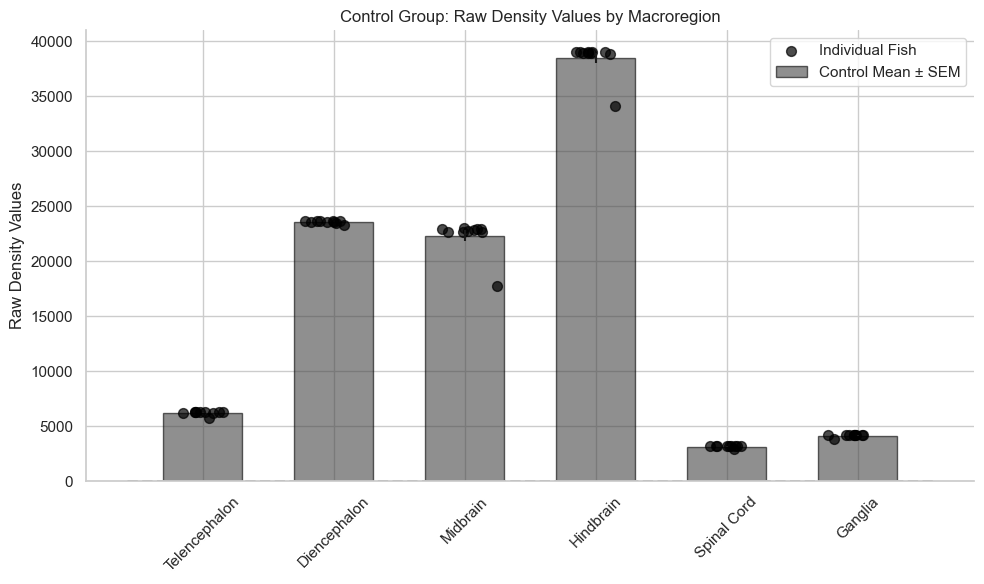

In [20]:
# Set Seaborn style
sns.set(style="whitegrid")

# Macro regions
macro_masks = ["Telencephalon", "Diencephalon", "Midbrain", "Hindbrain", "Spinal Cord", "Ganglia"]

# Define colors
bar_color = '#444444'   # Dark grey
dot_color = '#000000'   # Black

# Compute means, SEMs, and individual data
control_means = []
control_sems = []
control_scatter = {region: [] for region in macro_masks}

for macro in macro_masks:
    arrays = region_data_control.get(macro)
    if arrays:
        stacked = np.stack(arrays)  # shape (n_fish, data_points)
        region_means = np.mean(stacked, axis=1)  # mean per fish
        mean = region_means.mean()
        sem_val = sem(region_means)
        control_scatter[macro].extend(region_means)
    else:
        mean = np.nan
        sem_val = np.nan
    
    control_means.append(mean)
    control_sems.append(sem_val)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(macro_masks))
bar_width = 0.6

# Bar plot
ax.bar(x, control_means, yerr=control_sems, capsize=0, width=bar_width,
       color=bar_color, edgecolor='black', label='Control Mean ± SEM', alpha=0.6)

# Scatter plot (individual fish)
for j, region in enumerate(macro_masks):
    y_vals = control_scatter[region]
    jitter = np.random.normal(0, 0.1, size=len(y_vals))  # small jitter 
    x_vals = x[j] + jitter
    ax.scatter(x_vals, y_vals, color=dot_color, alpha=0.7, s=50,
               label='Individual Fish' if j == 0 else "")

# Final plot touches
ax.set_xticks(x)
ax.set_xticklabels(macro_masks, rotation=45)
ax.set_ylabel("Raw Density Values")
ax.set_title("Control Group: Raw Density Values by Macroregion")
ax.legend()
sns.despine(right=True, bottom=False)
plt.tight_layout()

xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, linewidth=2, color='grey', linestyles='dashed')

plt.show()

# Save plot
fig.savefig(r'D:\final\sleep_conditions_results\controls_data_Macro.pdf')


In [22]:
for macro in macro_masks:
    arrays = region_data_control.get(macro)
    print(f"{macro}: {len(arrays) if arrays else 0} arrays")

Telencephalon: 10 arrays
Diencephalon: 10 arrays
Midbrain: 10 arrays
Hindbrain: 10 arrays
Spinal Cord: 10 arrays
Ganglia: 10 arrays


### plots of SD and control groups BEFORE substracting

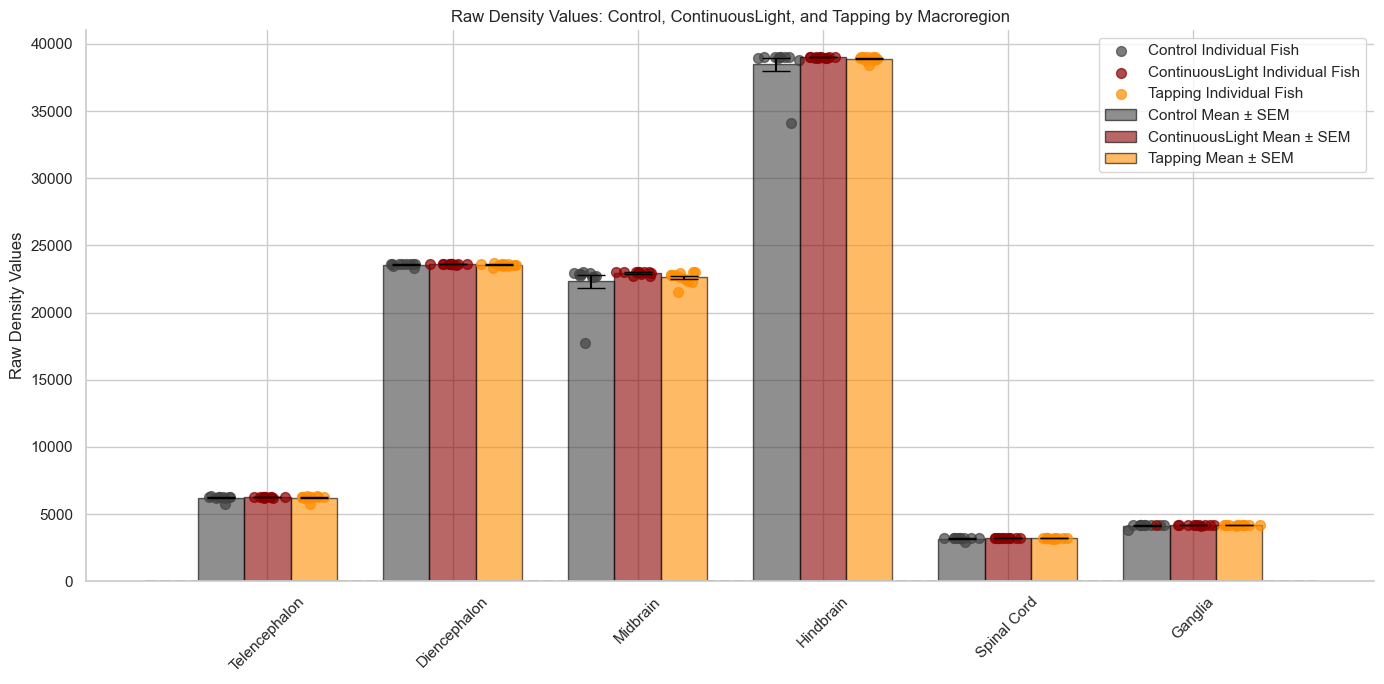

In [23]:
sns.set(style="whitegrid")

macro_masks = ["Telencephalon", "Diencephalon", "Midbrain", "Hindbrain", "Spinal Cord", "Ganglia"]
#macro_masks=["Region A","Region B","Region C","Region D","Region E"]
groups = ["Control", "ContinuousLight", "Tapping"]
colors = ['#444444', '#8B0000', '#FF8C00']

# Initialize dictionaries to hold processed data
group_means = {group: [] for group in groups}
group_sems = {group: [] for group in groups}
group_scatter = {group: {region: [] for region in macro_masks} for group in groups}

# Assume region_mean_treatment_raw was defined earlier
for group in groups:
    for macro in macro_masks:
        # Always use lists of arrays per group
        arrays = region_data_control.get(macro, []) if group == "Control" else region_mean_treatment_raw.get(group, {}).get(macro, [])

        if arrays:
            stacked = np.stack(arrays)
            region_means = np.mean(stacked, axis=1) if stacked.ndim > 1 else stacked
            mean = region_means.mean()
            sem_val = sem(region_means)
        else:
            mean = np.nan
            sem_val = np.nan
            region_means = []
        
        group_means[group].append(mean)
        group_sems[group].append(sem_val)
        group_scatter[group][macro].extend(region_means)


# Plotting
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(macro_masks))
bar_width = 0.25

for i, group in enumerate(groups):
    offset = (i - 1) * bar_width  # centers groups on x ticks
    ax.bar(x + offset, group_means[group],
           yerr=group_sems[group],
           error_kw=dict(ecolor='black', lw=1.5, capsize=10),
           alpha=0.6,
           width=bar_width,
           color=colors[i],
           edgecolor='black',
           label=f'{group} Mean ± SEM')

    # Plot individual fish points with group-specific legend label only once
    for j, region in enumerate(macro_masks):
        y_vals = group_scatter[group][region]
        jitter = np.random.normal(0, 0.05, size=len(y_vals))
        x_vals = np.full_like(y_vals, fill_value=x[j] + offset) + jitter
        ax.scatter(x_vals, y_vals, color=colors[i], alpha=0.7, s=50,
                   label=f'{group} Individual Fish' if j == 0 else "")

# Final touches
ax.set_xticks(x)
ax.set_xticklabels(macro_masks, rotation=45)
ax.set_ylabel("Raw Density Values")
ax.set_title("Raw Density Values: Control, ContinuousLight, and Tapping by Macroregion")
ax.legend()
#ax.set_ylim(-250,250)
sns.despine(right=True, bottom=False)
plt.tight_layout()

xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, linewidth=2, color='grey', linestyles='dashed')

plt.show()

fig.savefig(r'D:\final\sleep_conditions_results\plots_SD_controls_beforesubstracting_Macro.pdf')

## Statistics Macro masks-BEFORE substracting

In [24]:
#The ANOVA is using the individual-level raw data (not the group means).
#For each macroregion (e.g., Telencephalon), it performs a one-way ANOVA on the three group samples (based on the individual fish).
#It prints out the F-statistic and p-value.
#It ignores regions that don’t have enough data for all three groups.

print("One-way ANOVA results (per brain region):\n")

anova_results = []  # For saving to Excel

for region in macro_masks:
    control_vals = group_scatter["Control"][region]
    light_vals = group_scatter["ContinuousLight"][region]
    tapping_vals = group_scatter["Tapping"][region]

    # Remove any NaNs (in case they exist)
    control_vals = np.array(control_vals)[~np.isnan(control_vals)]
    light_vals = np.array(light_vals)[~np.isnan(light_vals)]
    tapping_vals = np.array(tapping_vals)[~np.isnan(tapping_vals)]

    if len(control_vals) > 1 and len(light_vals) > 1 and len(tapping_vals) > 1:
        f_stat, p_val = f_oneway(control_vals, light_vals, tapping_vals)
        print(f"{region}: F = {f_stat:.3f}, p = {p_val:.4f}")
        
        # Add result to Excel output
        anova_results.append({
            "Region": region,
            "F_statistic": round(f_stat, 3),
            "p_value": round(p_val, 4),
            "n_Control": len(control_vals),
            "n_ContinuousLight": len(light_vals),
            "n_Tapping": len(tapping_vals)
        })
    else:
        print(f"{region}: Not enough data for ANOVA")
        anova_results.append({
            "Region": region,
            "F_statistic": None,
            "p_value": None,
            "n_Control": len(control_vals),
            "n_ContinuousLight": len(light_vals),
            "n_Tapping": len(tapping_vals)
        })

# Save to Excel
anova_df = pd.DataFrame(anova_results)
output_path = r"D:\final\sleep_conditions_results\anova_results_raw_density.xlsx"
anova_df.to_excel(output_path, index=False, engine='openpyxl')

print(f"\n✅ ANOVA results also saved to: {output_path}")


One-way ANOVA results (per brain region):

Telencephalon: F = 0.704, p = 0.5027
Diencephalon: F = 2.299, p = 0.1183
Midbrain: F = 1.178, p = 0.3222
Hindbrain: F = 0.984, p = 0.3861
Spinal Cord: F = 1.080, p = 0.3529
Ganglia: F = 0.581, p = 0.5657

✅ ANOVA results also saved to: D:\final\sleep_conditions_results\anova_results_raw_density.xlsx


In [374]:
#if ANOVA showed statistically significant results
"""
tukey_results_list = []

for region in macro_masks:
    control_vals = group_scatter["Control"][region]
    light_vals = group_scatter["ContinuousLight"][region]
    tapping_vals = group_scatter["Tapping"][region]

    # Remove NaNs
    control_vals = np.array(control_vals)[~np.isnan(control_vals)]
    light_vals = np.array(light_vals)[~np.isnan(light_vals)]
    tapping_vals = np.array(tapping_vals)[~np.isnan(tapping_vals)]

    if len(control_vals) > 1 and len(light_vals) > 1 and len(tapping_vals) > 1:
        values = np.concatenate([control_vals, light_vals, tapping_vals])
        groups = (['Control'] * len(control_vals) +
                  ['ContinuousLight'] * len(light_vals) +
                  ['Tapping'] * len(tapping_vals))

        tukey = pairwise_tukeyhsd(endog=values, groups=groups, alpha=0.05)
        summary_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])

        # Add region name column for clarity
        summary_df['Region'] = region

        # Append to list
        tukey_results_list.append(summary_df)

# Concatenate all results into one DataFrame
all_tukey_results_df = pd.concat(tukey_results_list, ignore_index=True)

# Reorder columns for readability
all_tukey_results_df = all_tukey_results_df[['Region', 'group1', 'group2', 'meandiff', 'p-adj', 'lower', 'upper', 'reject']]

# Save to Excel
output_path = r"C:\Users\cbriziol\Documents\final\sleep_conditions_results\tukey_hsd_results.xlsx"
all_tukey_results_df.to_excel(output_path, index=False, engine='openpyxl')

print(f"✅ Tukey HSD results saved to: {output_path}")
"""

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 1398-1399: truncated \UXXXXXXXX escape (1835789207.py, line 2)

## Plotting the data AFTER subtracting the control mean + Performing statistical tests (t-tests) on those subtracted values

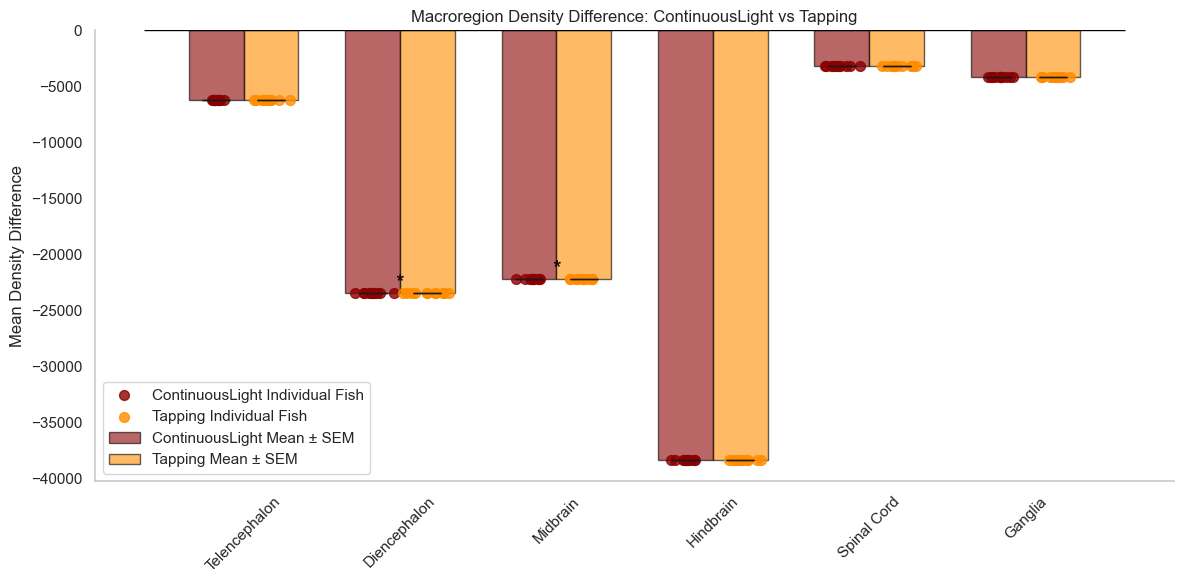

Statistics saved to D:\final\sleep_conditions_results\ttest_aftersubstracting_macro.xlsx


In [26]:
# plot substracted SD data with macro masks

#The data input to the plotting and stats part already has the control mean subtracted per larva, so it’s showing differences from control.
#Then it calculates mean and SEM per region per group (ContinuousLight and Tapping) based on those difference values.
#It runs t-tests comparing these two groups for each region.
#It plots the mean ± SEM bars for each group and region, along with individual larva points jittered for visibility.
#It adds stars on top of bars where the t-test shows statistical significance.
#What we see-> the plot are mean differences relative to control, grouped by region and treatment, with stats indicating where ContinuousLight and Tapping differ significantly.


sns.set(style="whitegrid")

macro_masks = ["Telencephalon", "Diencephalon", "Midbrain", "Hindbrain", "Spinal Cord", "Ganglia"]
groups = ["ContinuousLight", "Tapping"]
colors = ['#8B0000', '#FF8C00']  # Dark Red for ContinuousLight, Orange for Tapping

# Prepare data containers
group_means = {group: [] for group in groups}
group_sems = {group: [] for group in groups}
group_scatter = {group: {region: [] for region in macro_masks} for group in groups}

for group in groups:
    for macro in macro_masks:
        arrays = group_data[group].get(macro)
        if arrays:
            stacked = np.stack(arrays)
            region_means = np.mean(stacked, axis=1)  # mean per fish
            mean = region_means.mean()
            sem_val = sem(region_means)
        else:
            mean = np.nan
            sem_val = np.nan

        group_means[group].append(mean)
        group_sems[group].append(sem_val)

        if arrays:
            group_scatter[group][macro].extend(region_means)

# Function to return significance stars
def significance_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

# Prepare dataframe for Excel export
stats_data = {
    'Region': [],
    'ContinuousLight_Mean': [],
    'ContinuousLight_SEM': [],
    'ContinuousLight_n': [],
    'Tapping_Mean': [],
    'Tapping_SEM': [],
    'Tapping_n': [],
    't-test_p-value': [],
    'Significance': []
}

# Run stats and prepare for plot annotations
x = np.arange(len(macro_masks))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

for i, group in enumerate(groups):
    offset = (i - 0.5) * bar_width
    ax.bar(x + offset, group_means[group],
           yerr=group_sems[group],
           capsize=10, width=bar_width,
           color=colors[i], edgecolor='black',
           alpha=0.6,
           label=f'{group} Mean ± SEM')

    for j, region in enumerate(macro_masks):
        y_vals = group_scatter[group][region]
        x_vals = x[j] + offset + np.random.normal(0, 0.06, size=len(y_vals))
        label = f'{group} Individual Fish' if j == 0 else None  

        ax.scatter(x_vals, y_vals, color=colors[i], alpha=0.8, s=50, label=label)

# Add significance stars and collect stats for Excel
for j, region in enumerate(macro_masks):
    data_continuous = group_scatter["ContinuousLight"][region]
    data_tapping = group_scatter["Tapping"][region]

    if data_continuous and data_tapping:
        stat, pval = ttest_ind(data_continuous, data_tapping, equal_var=False)
    else:
        pval = np.nan

    star = significance_stars(pval)

    # Add stats to the dict for Excel
    stats_data['Region'].append(region)
    stats_data['ContinuousLight_Mean'].append(np.mean(data_continuous) if data_continuous else np.nan)
    stats_data['ContinuousLight_SEM'].append(sem(data_continuous) if data_continuous else np.nan)
    stats_data['ContinuousLight_n'].append(len(data_continuous))
    stats_data['Tapping_Mean'].append(np.mean(data_tapping) if data_tapping else np.nan)
    stats_data['Tapping_SEM'].append(sem(data_tapping) if data_tapping else np.nan)
    stats_data['Tapping_n'].append(len(data_tapping))
    stats_data['t-test_p-value'].append(pval)
    stats_data['Significance'].append(star)

    if star:
        y = max(group_means["ContinuousLight"][j], group_means["Tapping"][j]) + \
            max(group_sems["ContinuousLight"][j], group_sems["Tapping"][j]) + 0.1
        x_pos = x[j]
        ax.text(x_pos, y, star, ha='center', va='bottom', fontsize=16, color='black')

# Final tweaks
ax.set_xticks(x)
ax.set_xticklabels(macro_masks, rotation=45)
ax.set_ylabel("Mean Density Difference")
ax.set_title("Macroregion Density Difference: ContinuousLight vs Tapping")
ax.legend()
sns.despine(right=True, bottom=False)
plt.tight_layout()
ax.grid(False)
xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, linewidth=1, color='black', linestyles='solid')
plt.show()

# Save plot
fig.savefig(r'D:\final\sleep_conditions_results\macro_plots.pdf')

# Save stats to Excel
df_stats = pd.DataFrame(stats_data)
excel_path = r'D:\final\sleep_conditions_results\ttest_aftersubstracting_macro.xlsx'
df_stats.to_excel(excel_path, index=False)
print(f"Statistics saved to {excel_path}")


# Plots Mini Masks

In [28]:
mini_masks = ["Olfactory Bulb", "Pallium", "Subpallium", "Pineal", "Habenula", "Optic Tract and Accessory Optic System", 
              "Retinal Arborization Field 1 (AF1, Approximate Location)", "Retinal Arborization Field 2 (AF2, Approximate Location)", 
              "Retinal Arborization Field 3 (AF3)", "Retinal Arborization Field 4 (AF4)", "Retinal Arborization Field 5 (AF5)", 
              "Retinal Arborization Field 6 (AF6)", "Retinal Arborization Field 7 (AF7)", "Retinal Arborization Field 8 (AF8)", 
              "Retinal Arborization Field 9 (AF9)", "Pretectum", "Dorsal Thalamus", "Ventral Thalamus", "Preoptic Area", "Posterior Tuberculum", 
              "Preglomerular Complex (approximate area)", "Rostral Hypothalamus", "Intermediate Hypothalamus", 
              "Diffuse Nucleus of the Intermediate Hypothalamus", "Caudal Hypothalamus", "Pituitary", "Torus Longitudinalis", "Torus Semicircularis", 
              "Neuropil", "Stratum Periventriculare", "Tegmentum", "Oculomotor Nucleus nIII", "NucMLF (nucleus of the medial longitudinal fascicle)", 
              "Cerebellum", "Valvula Cerebellum", "Cerebellar Corpus", "Granular Eminence", "Medial Caudal Lobe", "Rhombomere 1", "Raphe - Superior", 
              "Interpeduncular Nucleus", "Locus Coeruleus", "Rhombomere 2", "Raphe - Superior1", "Locus Coeruleus1", "Rhombomere 3", "Raphe - Inferior", 
              "Rhombomere 4", "Raphe - Inferior1", "Rhombomere 5", "Raphe - Inferior2", "Rhombomere 6", "Raphe - Inferior3", "Rhombomere 7", 
              "Raphe - Inferior4", "Caudal Hindbrain", "Area Postrema", "Inferior Olive", "Lateral Reticular Nucleus", "RoL-R1", "RoL2", "RoM1", "RoM2", 
              "RoM3", "RoL3", "RoV3", "Mauthner", "Mauthner Cell Axon Cap", "MiV1", "MiM1", "MiR1", "MiR2", "MiD2", "MiV2", "MiD3", "MiT", "CaD", "CaV", 
              "Spinal Backfill Vestibular Population", "Tangential Vestibular Nucleus", "Tangential Vestibular Nucleus1", "Medial Vestibular Nucleus", 
              "Medial Vestibular Nucleus1", "Oculomotor Nucleus nIV", "Anterior Cluster of nV Trigeminal Motorneurons", 
              "Posterior Cluster of nV Trigeminal Motorneurons", "VII Facial Motor and octavolateralis efferent neurons", 
              "VII Facial Motor and octavolateralis efferent neurons1", "VII Facial Motor and octavolateralis efferent neurons2", 
              "X Vagus motorneuron cluster", "Olfactory Epithelium", "Facial Sensory Ganglion", "Facial glossopharyngeal ganglion", 
              "Statoacoustic Ganglion", "Trigeminal Ganglion", "Anterior Lateral Line Ganglion", "Posterior Lateral Line Ganglia", "Lateral Line Neuromast D1",
              "Lateral Line Neuromast D2", "Lateral Line Neuromast N", "Lateral Line Neuromast O1", "Lateral Line Neuromast OC1", "Lateral Line Neuromast SO1",
              "Lateral Line Neuromast SO2", "Lateral Line Neuromast SO3", "Vagal Ganglia"]

##control group

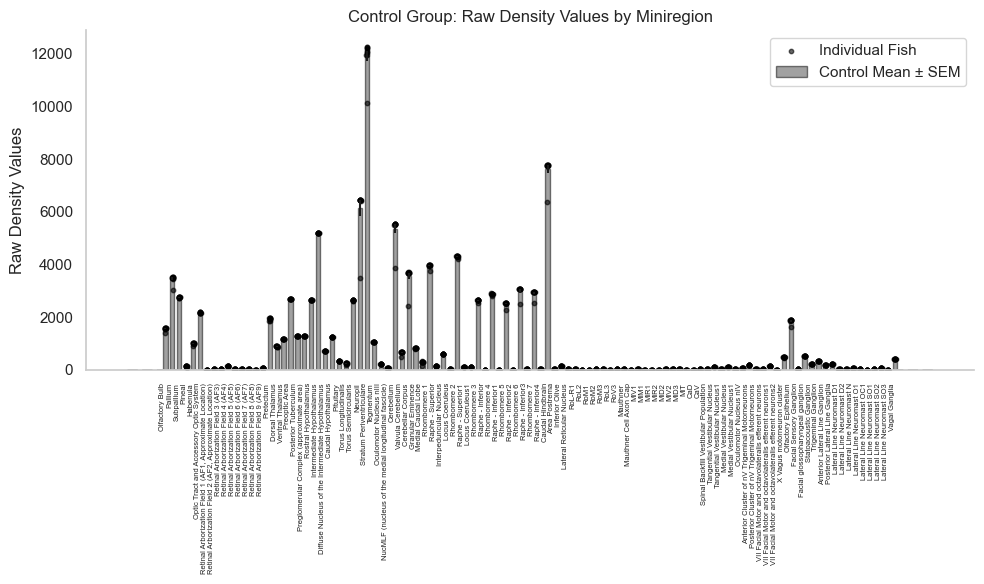

In [29]:
# plot controls
sns.set(style="whitegrid")


# Define colors
bar_color = '#444444'   # Dark grey
dot_color = '#000000'   # Black

# Compute means, SEMs, and collect individual fish means
control_means = []
control_sems = []
control_scatter = {region: [] for region in mini_masks}

for mini in mini_masks:
    arrays = region_data_control.get(mini)
    if arrays:
        stacked = np.stack(arrays)  # shape (n_fish, data_points)
        region_means = np.mean(stacked, axis=1)  # mean across data points per fish
        #print(region_means)
        mean = region_means.mean()
        sem_val = sem(region_means)
    else:
        mean = np.nan
        sem_val = np.nan
    
    control_means.append(mean)
    control_sems.append(sem_val)
    
    if arrays:
        control_scatter[mini].extend(region_means)
#print(control_scatter)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(mini_masks))
bar_width = 0.6

# Bar plot
ax.bar(x, control_means, yerr=control_sems, capsize=0, width=bar_width,
       color=bar_color, edgecolor='black', label='Control Mean ± SEM', alpha=0.5)

# Scatter plot (individual fish)
for j, region in enumerate(mini_masks):
    y_vals = control_scatter[region]
    jitter = np.random.normal(0, 0.05, size=len(y_vals))  # small random offsets
    x_vals = x[j] + jitter
    ax.scatter(x_vals, y_vals, color=dot_color, alpha=0.6, s=10,
               label='Individual Fish' if j == 0 else "")


# Final plot touches
ax.set_xticks(x)
ax.set_xticklabels(mini_masks, rotation=90, fontsize=5.5, ha='right')
plt.subplots_adjust(bottom=0.45)
ax.set_ylabel("Raw Density Values")
ax.set_title("Control Group: Raw Density Values by Miniregion")
ax.legend()
sns.despine(right=True, bottom=False)
plt.tight_layout()
ax.grid(False)

xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, linewidth=2, color='grey', linestyles='dashed')

plt.show()

fig.savefig(r'D:\final\sleep_conditions_results\controls_data_mini_masks.pdf')

SD + Control group Before substracting

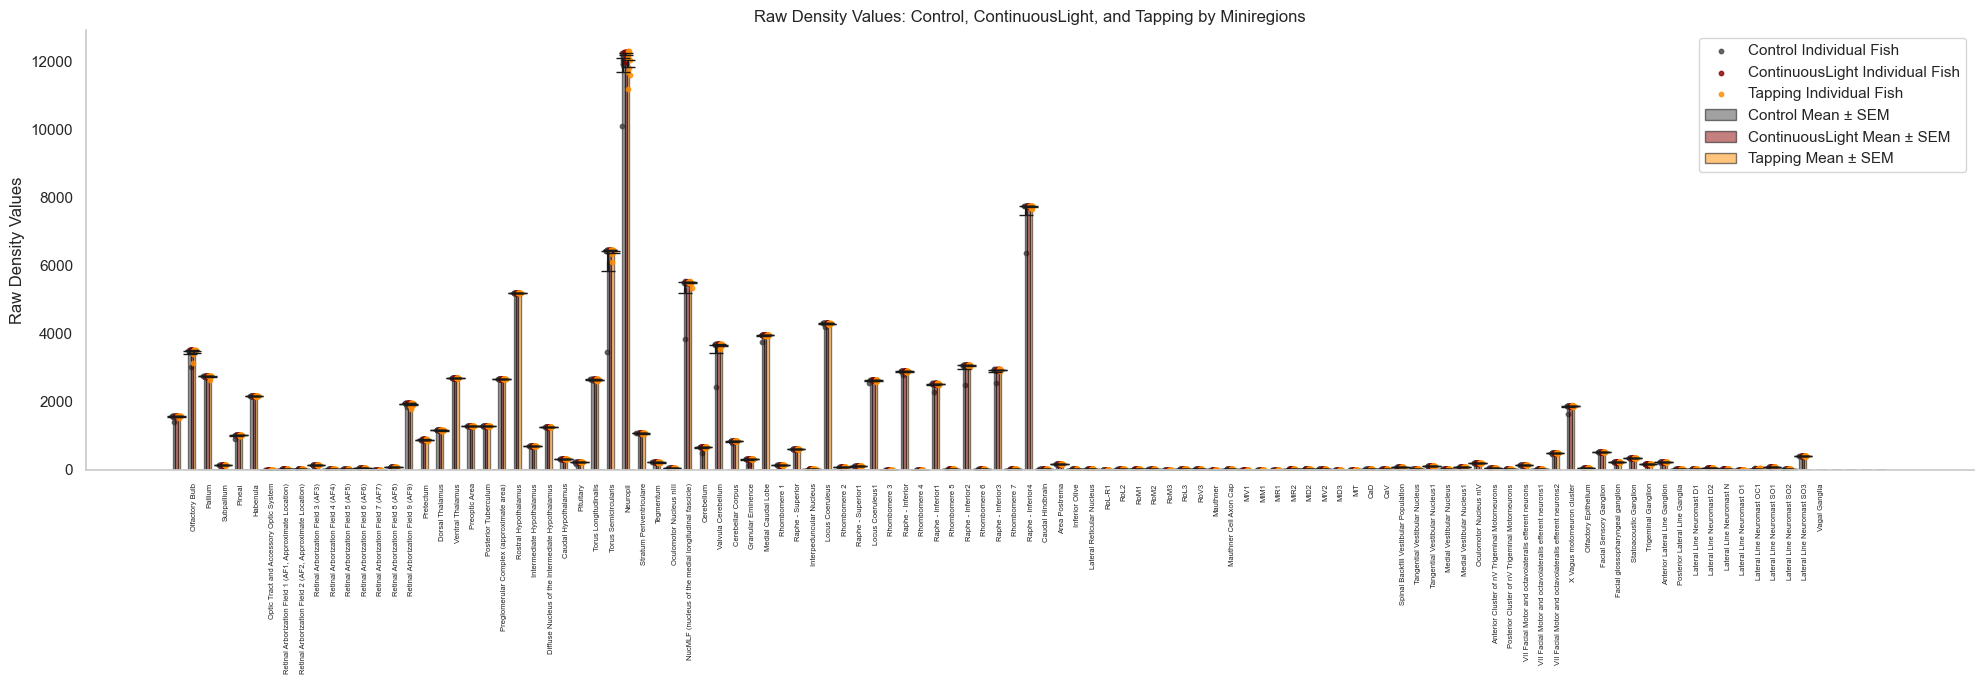

In [30]:
sns.set(style="whitegrid")

groups = ["Control", "ContinuousLight", "Tapping"]
colors = ['#444444', '#8B0000', '#FF8C00']

# Initialize dictionaries to hold processed data
group_means = {group: [] for group in groups}
group_sems = {group: [] for group in groups}
group_scatter = {group: {region: [] for region in mini_masks} for group in groups}

# Assume region_mean_treatment_raw was defined earlier
for group in groups:
    for mini in mini_masks:
        # Always use lists of arrays per group
        arrays = region_data_control.get(mini, []) if group == "Control" else region_mean_treatment_raw.get(group, {}).get(mini, [])

        if arrays:
            stacked = np.stack(arrays)
            region_means = np.mean(stacked, axis=1) if stacked.ndim > 1 else stacked
            mean = region_means.mean()
            sem_val = sem(region_means)
        else:
            mean = np.nan
            sem_val = np.nan
            region_means = []
        
        group_means[group].append(mean)
        group_sems[group].append(sem_val)
        group_scatter[group][mini].extend(region_means)


# Plotting
fig, ax = plt.subplots(figsize=(20, 7))

x = np.arange(len(mini_masks))
bar_width = 0.15

for i, group in enumerate(groups):
    offset = (i - 10) * bar_width  # adjust as you need
    ax.bar(x + offset, group_means[group], yerr=group_sems[group], capsize=5, alpha=0.5,
           width=bar_width, color=colors[i], edgecolor='black', label=f'{group} Mean ± SEM')

    # Plot individual fish points with group-specific label only once
    for j, region in enumerate(mini_masks):
        y_vals = group_scatter[group][region]
        jitter = np.random.normal(0, 0.05, size=len(y_vals))
        x_vals = np.full_like(y_vals, fill_value=x[j] + offset) + jitter
        ax.scatter(x_vals, y_vals, color=colors[i], alpha=0.8, s=10,
                   label=f'{group} Individual Fish' if j == 0 else "")



# Final touches
ax.set_xticks(x)
ax.set_xticklabels(mini_masks, rotation=90, fontsize=5.5, ha='right')
plt.subplots_adjust(bottom=0.45)
ax.set_ylabel("Raw Density Values")
ax.set_title("Raw Density Values: Control, ContinuousLight, and Tapping by Miniregions")
ax.legend()
#ax.set_ylim(-250,250)
sns.despine(right=True, bottom=False)
ax.grid(False)
plt.tight_layout()

xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=0, xmax=xmax, linewidth=2, color='grey', linestyles='dashed')

plt.show()

fig.savefig(r'D:\final\sleep_conditions_results\plots_SD_controls_beforesubstracting_Mini.pdf')

## Statistics Mini masks-BEFORE substracting

In [31]:
print("One-way ANOVA results (per mini-region):\n")

anova_results = []  # For Excel export

for region in mini_masks:
    control_vals = group_scatter["Control"].get(region, [])
    light_vals = group_scatter["ContinuousLight"].get(region, [])
    tapping_vals = group_scatter["Tapping"].get(region, [])

    # Convert to numpy arrays and remove NaNs
    control_vals = np.array(control_vals)
    light_vals = np.array(light_vals)
    tapping_vals = np.array(tapping_vals)

    control_vals = control_vals[~np.isnan(control_vals)]
    light_vals = light_vals[~np.isnan(light_vals)]
    tapping_vals = tapping_vals[~np.isnan(tapping_vals)]

    if len(control_vals) > 1 and len(light_vals) > 1 and len(tapping_vals) > 1:
        f_stat, p_val = f_oneway(control_vals, light_vals, tapping_vals)
        print(f"{region}: F = {f_stat:.3f}, p = {p_val:.4f}")
        
        anova_results.append({
            "Region": region,
            "F_statistic": round(f_stat, 3),
            "p_value": round(p_val, 4),
            "n_Control": len(control_vals),
            "n_ContinuousLight": len(light_vals),
            "n_Tapping": len(tapping_vals)
        })
    else:
        print(f"{region}: Not enough data for ANOVA")
        anova_results.append({
            "Region": region,
            "F_statistic": None,
            "p_value": None,
            "n_Control": len(control_vals),
            "n_ContinuousLight": len(light_vals),
            "n_Tapping": len(tapping_vals)
        })

anova_df = pd.DataFrame(anova_results)

# At the end, print a clear summary of significant results
significant_anova_df = anova_df[(anova_df['p_value'] < 0.05) & (anova_df['p_value'].notnull())]

print("\n" + "="*60)
print("SUMMARY: Significant ANOVA results (p < 0.05):")
print(significant_anova_df[['Region', 'F_statistic', 'p_value', 'n_Control', 'n_ContinuousLight', 'n_Tapping']])
print("="*60 + "\n")

# Save results as before
output_path = r"D:\final\sleep_conditions_results\anova_results_raw_density_MINI.xlsx"
anova_df.to_excel(output_path, index=False, engine='openpyxl')

print(f"✅ All ANOVA results saved to: {output_path}")


One-way ANOVA results (per mini-region):

Olfactory Bulb: F = 0.887, p = 0.4227
Pallium: F = 0.634, p = 0.5378
Subpallium: F = 0.896, p = 0.4192
Pineal: F = 1.140, p = 0.3337
Habenula: F = 1.761, p = 0.1897
Optic Tract and Accessory Optic System: F = 3.091, p = 0.0607
Retinal Arborization Field 1 (AF1, Approximate Location): F = nan, p = nan
Retinal Arborization Field 2 (AF2, Approximate Location): F = 1.108, p = 0.3439
Retinal Arborization Field 3 (AF3): F = 0.843, p = 0.4406
Retinal Arborization Field 4 (AF4): F = 0.826, p = 0.4477
Retinal Arborization Field 5 (AF5): F = 3.072, p = 0.0617
Retinal Arborization Field 6 (AF6): F = 1.655, p = 0.2086
Retinal Arborization Field 7 (AF7): F = 2.955, p = 0.0679
Retinal Arborization Field 8 (AF8): F = 1.542, p = 0.2310
Retinal Arborization Field 9 (AF9): F = 0.975, p = 0.3893
Pretectum: F = 2.852, p = 0.0740
Dorsal Thalamus: F = 3.034, p = 0.0636
Ventral Thalamus: F = 3.274, p = 0.0522
Preoptic Area: F = 1.936, p = 0.1625
Posterior Tuberculum:

C:\Users\cbriziol\AppData\Local\miniconda3\envs\cfos\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


✅ All ANOVA results saved to: D:\final\sleep_conditions_results\anova_results_raw_density_MINI.xlsx


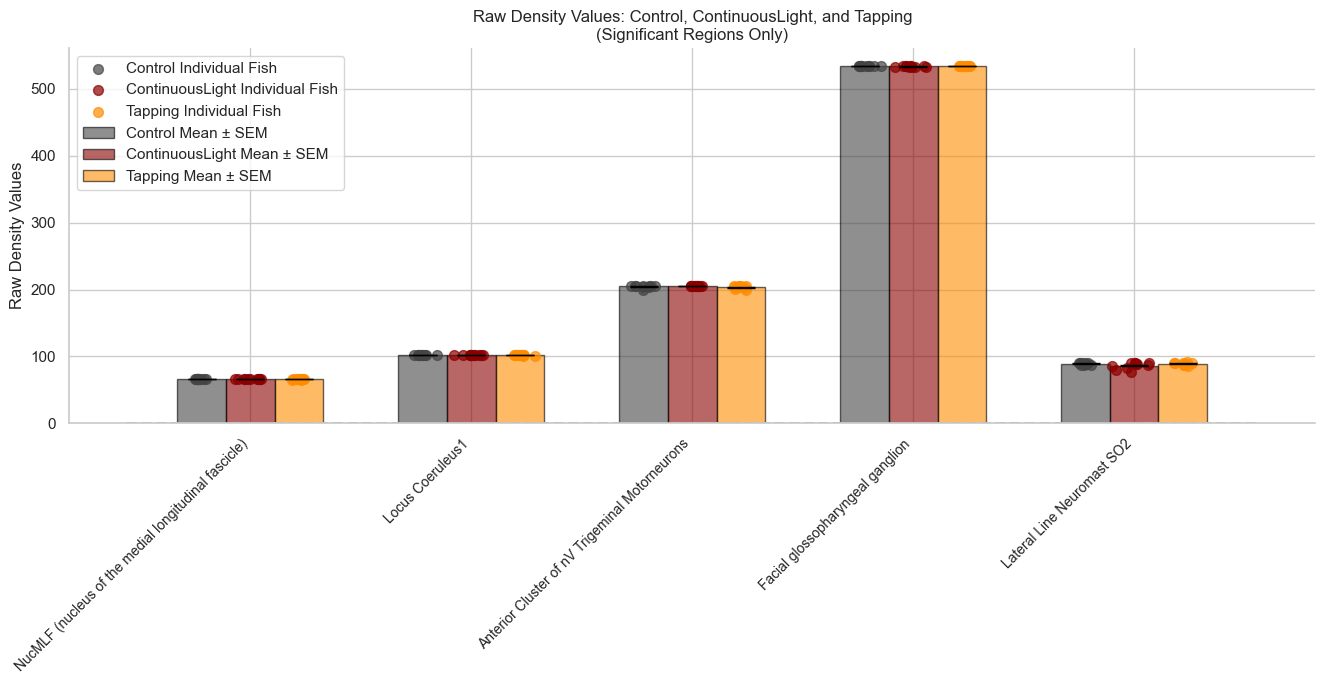

In [32]:
sns.set(style="whitegrid")

# Your significant regions exactly as you want to label them:
significant_regions = significant_anova_df['Region'].tolist()


groups = ["Control", "ContinuousLight", "Tapping"]
colors = ['#444444', '#8B0000', '#FF8C00']

# Initialize dictionaries to hold processed data for significant regions
group_means = {group: [] for group in groups}
group_sems = {group: [] for group in groups}
group_scatter = {group: {region: [] for region in significant_regions} for group in groups}

for group in groups:
    for region in significant_regions:
        if group == "Control":
            arrays = region_data_control.get(region, [])
        else:
            arrays = region_mean_treatment_raw.get(group, {}).get(region, [])

        if arrays:
            stacked = np.stack(arrays)
            region_means = np.mean(stacked, axis=1) if stacked.ndim > 1 else stacked
            mean = region_means.mean()
            sem_val = sem(region_means)
        else:
            mean = np.nan
            sem_val = np.nan
            region_means = []

        group_means[group].append(mean)
        group_sems[group].append(sem_val)
        group_scatter[group][region].extend(region_means)

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(significant_regions))
bar_width = 0.22  # slightly bigger bars

for i, group in enumerate(groups):
    offset = (i - 1) * bar_width  # center groups on each tick
    ax.bar(x + offset, group_means[group],
           yerr=group_sems[group],
           error_kw=dict(ecolor='black', lw=1.5, capsize=10),
           alpha=0.6,
           width=bar_width,
           color=colors[i],
           edgecolor='black',
           label=f'{group} Mean ± SEM')

    # Scatter individual fish points
    for j, region in enumerate(significant_regions):
        y_vals = group_scatter[group][region]
        jitter = np.random.normal(0, 0.03, size=len(y_vals))
        x_vals = np.full_like(y_vals, fill_value=x[j] + offset) + jitter
        ax.scatter(x_vals, y_vals, color=colors[i], alpha=0.7, s=50,
                   label=f'{group} Individual Fish' if j == 0 else "")

# Final touches
ax.set_xticks(x)
ax.set_xticklabels(significant_regions, rotation=45, ha='right', fontsize=10)
ax.set_ylabel("Raw Density Values")
ax.set_title("Raw Density Values: Control, ContinuousLight, and Tapping\n(Significant Regions Only)")
ax.legend()
sns.despine(right=True, bottom=False)
plt.tight_layout()

xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, linewidth=2, color='grey', linestyles='dashed')

plt.show()

fig.savefig(r'D:\final\sleep_conditions_results\plots_SD_controls_significant_regions_Mini.pdf')


In [38]:
import pandas as pd
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Assuming significant_anova_df comes from the MINI-level ANOVA
significant_regions = significant_anova_df['Region'].tolist()
all_tukey_results = []  # To collect all results for export

print("Post-hoc Tukey HSD results:\n")

for region in significant_regions:
    control_vals = group_scatter["Control"][region]
    light_vals = group_scatter["ContinuousLight"][region]
    tapping_vals = group_scatter["Tapping"][region]

    # Clean NaNs
    control_vals = np.array(control_vals)[~np.isnan(control_vals)]
    light_vals = np.array(light_vals)[~np.isnan(light_vals)]
    tapping_vals = np.array(tapping_vals)[~np.isnan(tapping_vals)]

    # Combine data and create group labels
    data = np.concatenate([control_vals, light_vals, tapping_vals])
    groups = (["Control"] * len(control_vals) + 
              ["ContinuousLight"] * len(light_vals) + 
              ["Tapping"] * len(tapping_vals))

    # Run Tukey HSD
    tukey = pairwise_tukeyhsd(endog=data, groups=groups, alpha=0.05)

    # Print to console
    print(f"Region: {region}")
    print(tukey.summary())
    print("\n" + "-"*50 + "\n")

    # Save this region's results into a DataFrame
    summary_df = pd.DataFrame(
        tukey.summary().data[1:],  # Skip header
        columns=tukey.summary().data[0]
    )
    summary_df.insert(0, "Region", region)
    all_tukey_results.append(summary_df)

# Concatenate all results and save
all_tukey_results_df = pd.concat(all_tukey_results, ignore_index=True)

output_path = r"D:\final\sleep_conditions_results\tukey_hsd_results_significantMINI.xlsx"
all_tukey_results_df.to_excel(output_path, index=False, engine='openpyxl')

print(f"✅ Tukey HSD results saved correctly to: {output_path}")


Post-hoc Tukey HSD results:

Region: NucMLF (nucleus of the medial longitudinal fascicle)
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
     group1      group2 meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
ContinuousLight Control  -0.0891  0.894 -0.5762   0.398  False
ContinuousLight Tapping  -0.5096 0.0337  -0.985 -0.0342   True
        Control Tapping  -0.4205 0.1009 -0.9076  0.0666  False
--------------------------------------------------------------

--------------------------------------------------

Region: Locus Coeruleus1
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
     group1      group2 meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
ContinuousLight Control  -0.1013 0.8869 -0.6365  0.4338  False
ContinuousLight Tapping  -0.5547 0.0356  -1.077 -0.0324   True
        Control Tapping  -0.4533 0.1091 -0.9885  0.0818  False
-------------

## Plotting data after substracting the control mean + performing t-test on the substracted values

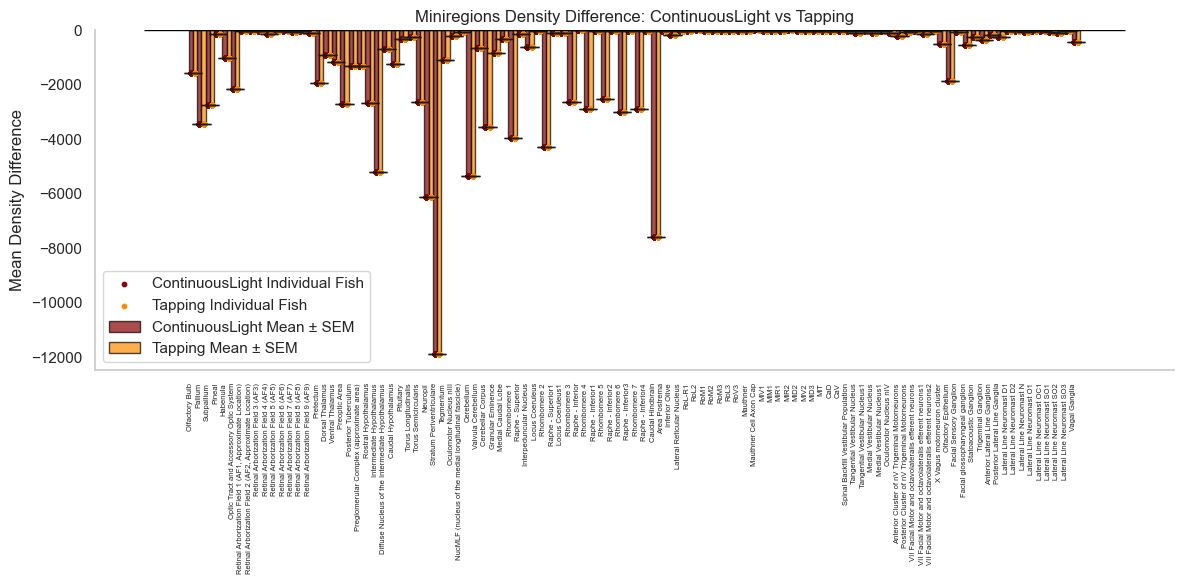

                                               Region    t_stat   p_value  \
15                                          Pretectum  2.412705  0.033569   
16                                    Dorsal Thalamus  2.416063  0.030205   
17                                   Ventral Thalamus  2.192962  0.048087   
20           Preglomerular Complex (approximate area)  2.595912  0.023224   
29                           Stratum Periventriculare  2.476939  0.029054   
32  NucMLF (nucleus of the medial longitudinal fas...  2.295089  0.044579   
42                                       Rhombomere 2  2.873033  0.015264   
44                                   Locus Coeruleus1  2.446374  0.030712   
45                                       Rhombomere 3  2.483075  0.031503   
47                                       Rhombomere 4  2.546358  0.027386   
81                          Medial Vestibular Nucleus  2.978660  0.013302   
83                             Oculomotor Nucleus nIV  2.466353  0.033096   

C:\Users\cbriziol\AppData\Local\miniconda3\envs\cfos\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [45]:
sns.set(style="whitegrid")

groups = ["ContinuousLight", "Tapping"]
colors = ['#8B0000', '#FF8C00']

# Prepare data
group_means = {group: [] for group in groups}
group_sems = {group: [] for group in groups}
group_scatter = {group: {region: [] for region in mini_masks} for group in groups}

for group in groups:
    for mini in mini_masks:
        arrays = group_data[group].get(mini)
        if arrays:
            stacked = np.stack(arrays)
            region_means = np.mean(stacked, axis=1)  # mean per fish
            mean = region_means.mean()
            sem_val = sem(region_means)
        else:
            mean = np.nan
            sem_val = np.nan

        group_means[group].append(mean)
        group_sems[group].append(sem_val)
        
        if arrays:
            group_scatter[group][mini].extend(region_means)

# --- PLOT ---
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(mini_masks))
bar_width = 0.5

for i, group in enumerate(groups):
    offset = (i - 0.5) * bar_width
    ax.bar(x + offset, group_means[group], 
       yerr=group_sems[group],
       capsize=5, width=bar_width, 
       color=colors[i], edgecolor='black', 
       alpha=0.7,
       label=f'{group} Mean ± SEM')

    # Add individual data points
    for j, region in enumerate(mini_masks):
        y_vals = group_scatter[group][region]
        x_vals = np.full_like(y_vals, fill_value=x[j] + offset)
        ax.scatter(x_vals, y_vals, color=colors[i], alpha=1, s=10, label=f'{group} Individual Fish' if j == 0 else "")

# Final plot tweaks
ax.set_xticks(x)
ax.set_xticklabels(mini_masks, rotation=90, fontsize=5.5, ha='right')
plt.subplots_adjust(bottom=0.45)
ax.set_ylabel("Mean Density Difference")
ax.set_title("Miniregions Density Difference: ContinuousLight vs Tapping")
ax.legend()
sns.despine(right=True, bottom=False)
plt.tight_layout()
ax.grid(False)
xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, linewidth=1, color='black', linestyles='solid')
plt.show()

# Save figure
fig.savefig(r'D:\final\sleep_conditions_results\mini_plots_aftersubstraction.pdf')

# --- T-TEST & EXPORT TO EXCEL ---
# Perform t-tests
results = []

for region in mini_masks:
    data_cl = group_scatter["ContinuousLight"][region]
    data_tp = group_scatter["Tapping"][region]

    if data_cl and data_tp:  # make sure data exists
        t_stat, p_val = ttest_ind(data_cl, data_tp, equal_var=False, nan_policy='omit')
    else:
        t_stat, p_val = np.nan, np.nan

    results.append({
        'Region': region,
        't_stat': t_stat,
        'p_value': p_val
    })

df_results = pd.DataFrame(results)

# Add significance column
df_results['Significant'] = df_results['p_value'] < 0.05

# Filter significant results
significant_results = df_results[df_results['Significant']]
print(significant_results)

# Save to Excel
output_path_full = r'D:\final\sleep_conditions_results\t_test_results_MINI_aftersubstraction.xlsx'
with pd.ExcelWriter(output_path_full) as writer:
    df_results.to_excel(writer, sheet_name='All_Results', index=False)
    significant_results.to_excel(writer, sheet_name='Significant_Results', index=False)

print(f"Results saved to {output_path_full} with two sheets: All_Results and Significant_Results")


Statistical Comparison (ContinuousLight vs Tapping):

Region: Pretectum
  ContinuousLight (n=11), Mean=-1931.040
  Tapping         (n=11), Mean=-1931.196
  t-statistic = 2.413, p-value = 0.0336, Cohen's d = 1.029

Region: Dorsal Thalamus
  ContinuousLight (n=11), Mean=-885.934
  Tapping         (n=11), Mean=-885.973
  t-statistic = 2.416, p-value = 0.0302, Cohen's d = 1.030

Region: Ventral Thalamus
  ContinuousLight (n=11), Mean=-1165.536
  Tapping         (n=11), Mean=-1165.572
  t-statistic = 2.193, p-value = 0.0481, Cohen's d = 0.935

Region: Preglomerular Complex (approximate area)
  ContinuousLight (n=11), Mean=-1296.545
  Tapping         (n=11), Mean=-1296.560
  t-statistic = 2.596, p-value = 0.0232, Cohen's d = 1.107

Region: Stratum Periventriculare
  ContinuousLight (n=11), Mean=-11865.143
  Tapping         (n=11), Mean=-11866.191
  t-statistic = 2.477, p-value = 0.0291, Cohen's d = 1.056

Region: NucMLF (nucleus of the medial longitudinal fascicle)
  ContinuousLight (n=11), 

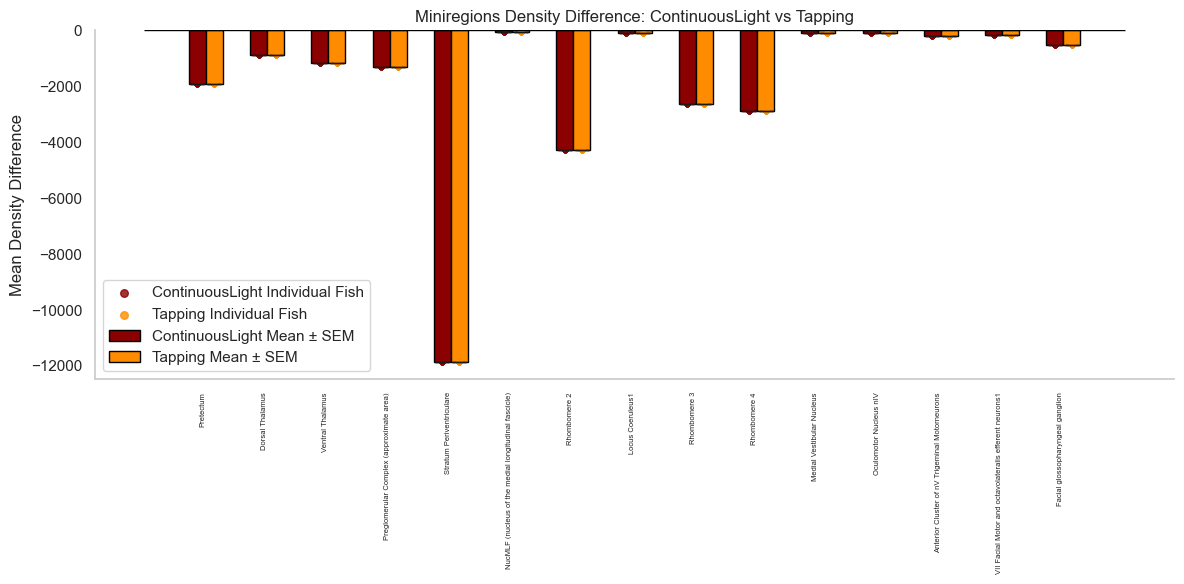

In [46]:
# === Function to compute Cohen's d ===
def cohen_d(a, b):
    return (np.mean(a) - np.mean(b)) / np.sqrt((np.std(a, ddof=1) ** 2 + np.std(b, ddof=1) ** 2) / 2)

# === Plotting setup ===
sns.set(style="whitegrid")
mini_masks = list(significant_results['Region'])
groups = ["ContinuousLight", "Tapping"]
colors = ['#8B0000', '#FF8C00']

group_means = {group: [] for group in groups}
group_sems = {group: [] for group in groups}
group_scatter = {group: {region: [] for region in mini_masks} for group in groups}

# === Aggregate data ===
for group in groups:
    for mini in mini_masks:
        arrays = group_data[group].get(mini)
        if arrays:
            stacked = np.stack(arrays)
            region_means = np.mean(stacked, axis=1)
            mean = region_means.mean()
            sem_val = sem(region_means)
        else:
            mean = np.nan
            sem_val = np.nan

        group_means[group].append(mean)
        group_sems[group].append(sem_val)

        if arrays:
            group_scatter[group][mini].extend(region_means)

# === Plotting ===
fig, ax = plt.subplots(figsize=(12, 6))
spacing_factor = 1.8
x = np.arange(len(mini_masks)) * spacing_factor
bar_width = 0.5

for i, group in enumerate(groups):
    offset = (i - 0.5) * bar_width
    ax.bar(x + offset, group_means[group],
           yerr=group_sems[group], capsize=5, width=bar_width,
           color=colors[i], edgecolor='black',
           label=f'{group} Mean ± SEM')

    for j, region in enumerate(mini_masks):
        y_vals = group_scatter[group][region]
        x_vals = np.full_like(y_vals, fill_value=x[j] + offset)
        ax.scatter(x_vals, y_vals, color=colors[i], alpha=0.8, s=10, label=None)

# === Legend for individuals ===
for i, group in enumerate(groups):
    ax.scatter([], [], color=colors[i], alpha=0.8, s=30, label=f'{group} Individual Fish')

# === Final plot adjustments ===
ax.set_xticks(x)
ax.set_xticklabels(mini_masks, rotation=90, fontsize=5.5, ha='right')
plt.subplots_adjust(bottom=0.45)
ax.set_ylabel("Mean Density Difference")
ax.set_title("Miniregions Density Difference: ContinuousLight vs Tapping")
ax.legend()
sns.despine(right=True, bottom=False)
ax.grid(False)
xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, linewidth=1, color='black', linestyles='solid')
bottom, _ = ax.get_ylim()
ax.set_ylim(bottom, 0)

# === Statistical analysis and saving ===
print("Statistical Comparison (ContinuousLight vs Tapping):\n")
stat_results = []

for region in mini_masks:
    data_cl = np.array(group_scatter["ContinuousLight"][region])
    data_tp = np.array(group_scatter["Tapping"][region])
    data_cl = data_cl[~np.isnan(data_cl)]
    data_tp = data_tp[~np.isnan(data_tp)]

    t_stat, p_val = ttest_ind(data_cl, data_tp, equal_var=False)
    d_val = cohen_d(data_cl, data_tp)

    print(f"Region: {region}")
    print(f"  ContinuousLight (n={len(data_cl)}), Mean={np.mean(data_cl):.3f}")
    print(f"  Tapping         (n={len(data_tp)}), Mean={np.mean(data_tp):.3f}")
    print(f"  t-statistic = {t_stat:.3f}, p-value = {p_val:.4f}, Cohen's d = {d_val:.3f}\n")

    stat_results.append({
        "Region": region,
        "CL_n": len(data_cl),
        "CL_mean": np.mean(data_cl),
        "TP_n": len(data_tp),
        "TP_mean": np.mean(data_tp),
        "t_stat": t_stat,
        "p_value": p_val,
        "cohen_d": d_val
    })

# === Save results ===
df_stats = pd.DataFrame(stat_results)
excel_path = r'D:\final\sleep_conditions_results\statistical_comparison_SD_significantMINI_aftersubstraction_with_effectsize.xlsx'
df_stats.to_excel(excel_path, index=False)
print(f"\nStatistical comparison saved to: {excel_path}")

# === Save plot ===
plot_path = r'D:\final\sleep_conditions_results\statistical_comparison_SD_significantMINI_aftersubstraction.pdf'
fig.savefig(plot_path)
print(f"Plot saved to: {plot_path}")

plt.tight_layout()
plt.show()
